## Scripts for Creating the Mock Datasets

In [1]:
#importing necessary libraries
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from datetime import datetime, timedelta, date
%matplotlib inline

#disabling warnings for cleaner presentation
import warnings
warnings.filterwarnings("ignore")

#importing dataframes with pre-established .csv formats
cus_df = pd.read_csv('mock_data/mock_client.csv',sep=';')
acc_df = pd.read_csv('mock_data/mock_account.csv',sep=';')
trans_df = pd.read_csv('mock_data/mock_trans.csv',sep=';')

### Functions for Creating Customer Data
Customer data is the most independant dataset, and contains little overlap with the others. To create the data, each of the fields are randomised from a procured list of options. Using the script, as many customers as desired can be created. After the customer data is built, the account data can be created, followed by the transaction data.

Currently, the data is not weighted towards a specific outcome, and generates random values. The outputs may not be considered fairly realistic, however serve as a good basis for our research.

### Customer Data

**client_id:**  The unique ID given to the customer.<br/>
**first_name:** The customer's first name. <br/>
**last_name:**  The customer's last name. <br/>
**dob:**        The customer's date of birth. <br/>
**join_date:**  The date the customer signed up to the bank. <br/>
**postcode:**   The customer's postcode (used for location identification). <br/>

In [2]:
def create_customer_data(cus_df,num_records):
    """
    This function generates a dataframe that contains a specified number of randomised customers.
    """
    
    i = 0
    
    while i < num_records:      
        #giving customers names
        cus_df.at[i,'first_name'] = choose_random(firstnames)
        cus_df.at[i,'last_name'] = choose_random(lastnames)
        
        #giving customers dates of birth
        cus_df.at[i,'dob'] = generate_datetime(1985,2001)
        
        #giving customers join date
        cus_df.at[i,'join_date'] = generate_datetime(2015,2018)
        #creating join date based off birthday
        #cus_df.at[i,'join_date'] = generate_datetime(cus_df.at[i,'dob'].year+18,2019)
        
        #giving customers postcodes
        cus_df.at[i,'postcode'] = choose_random(postcodes)
        
        #increment
        i+=1
        
    #sorting by date
    cus_df = cus_df.sort_values(by=['join_date'])
    
    #resetting index
    cus_df = cus_df.reset_index(drop=True)
    
    #loop to give ids in chronological order
    i = 0
    while i < cus_df.shape[0]:
        cus_df.at[i,'client_id'] = i+1
        i+=1
    
    #making account ID the index of the dataframe
    cus_df = cus_df.set_index("client_id", drop = True)
        
    return cus_df

### Account Data

**account_id:** Unique identifier for the account.<br/>
**client_id:** The customer to whom the accont belongs.<br/>
**account_name:** What the account is named (used for categorising purpose of account).<br/>
**date_created:** The date the account was created.<br/>
**balance:** The current balance of the account.<br/>

In [3]:
def create_account_data(acc_df,cus_df):
    """
    This function generates a dataframe that contains a specified number of randomised accounts based on
    a dataframe of customers.
    """
    
    i = 0
    
    while i < cus_df.shape[0]:
        #assigning customer IDs to an account
        acc_df.at[i,'client_id'] = i+1
        
        #giving account a name
        #TODO
        
        #giving account date of creation based on birth date of customer
        acc_df.at[i,'date_created'] = generate_datetime(cus_df.at[acc_df.at[i,'client_id'],'join_date'].year,2018)
        
        #giving account a balance
        acc_df.at[i,'balance'] = round(random.uniform(100,10000),2)
        
        i+=1
    
    
    #sorting by date
    acc_df = acc_df.sort_values(by=['date_created'])
    
    #resetting index
    acc_df = acc_df.reset_index(drop=True)
    
    #loop to give ids in chronological order
    i = 0
    while i < acc_df.shape[0]:
        acc_df.at[i,'account_id'] = i+1
        i+=1
    
    #making account ID the index of the dataframe
    acc_df = acc_df.set_index("account_id", drop = True)
    
    return acc_df

### Transaction Data
**trans_id:** The unique ID given to every new transaction.<br/>
**account_id:** The account ID of the person making the transaction.<br/>
**date:** The date the transaction occured.<br/>
**merchant_type:** The nature of the transaction.<br/>
**operation:** Whether the funds are ingoing or outgoing.<br/>
**amount:** The amount of money involved in the transaction.<br/>
**new_balance:** The balance after the transaction.<br/>
**account_to:** The account ID of the party involved in the transaction receiving the money(for transfers and transactions with vendors).<br/>
**account_from:** The account ID of the party involved in the transaction sending the money (for transfers and transactions with vendors).<br/>

In [4]:
def create_transaction_data(trans_df,cus_df,acc_df,num_records):
    """
    This function generates a dataframe that contains a specified number of randomised transactions based on
    a dataframe of customers and accounts. It returns both the transaction dataframe and account dataframe
    because both of these have been updated in this function and the updates must be reflected.
    """
    i = 0
    
    while i < num_records:
        #giving transaction an account number
        trans_df.at[i,'account_id'] = int(choose_random(acc_df.index.tolist()))
        
        #giving transaction a date
        trans_df.at[i,'date'] = generate_datetime_recent(acc_df.at[int(trans_df.at[i,'account_id']),'date_created'])
        
        #giving merchant type of transaction
        trans_df.at[i,'merchant_type'] = choose_random(typelist)
        
        #giving operation of transaction
        if trans_df.at[i,'merchant_type'] == 'Income' or trans_df.at[i,'merchant_type'] == 'Transfer to Account':
            trans_df.at[i,'operation'] = 'deposit'
        else:
            trans_df.at[i,'operation'] = 'withdrawal'
        
        #giving transaction amount
        trans_df.at[i,'amount'] = round(random.uniform(1,100),2)
        
        #giving initial balance amount
        trans_df.at[i,'new_balance'] = acc_df.at[int(trans_df.at[i,'account_id']),'balance']
        
        i+=1
        
    
    trans_df = trans_df.append(add_sub_data(trans_df,acc_df),ignore_index=True)
    
    #sorting by date
    trans_df = trans_df.sort_values(by=['date'])
    
    #resetting index
    trans_df = trans_df.reset_index(drop=True)
    
    #loop to give ids in chronological order
    i = 0
    while i < trans_df.shape[0]:
        trans_df.at[i,'trans_id'] = i+1
        #updating balance to reflect transaction
        
        trans_df.at[i,'account_to'] = add_store(trans_df.at[i,'merchant_type'])
        
        if trans_df.at[i,'operation'] == 'deposit':
            acc_df.at[int(trans_df.at[i,'account_id']),'balance'] = (acc_df.at[int(trans_df.at[i,'account_id']),'balance']  
                                                                     + trans_df.at[i,'amount'])
        else:
            acc_df.at[int(trans_df.at[i,'account_id']),'balance'] = (acc_df.at[int(trans_df.at[i,'account_id']),'balance']  
                                                                     - trans_df.at[i,'amount'])
            
        trans_df.at[i,'new_balance'] = acc_df.at[int(trans_df.at[i,'account_id']),'balance']
        
        i+=1
    
    #making transaction ID the index of the dataframe
    trans_df = trans_df.set_index("trans_id", drop = True)
    
    #returning the edited dataframes as a list to be allocated once passed
    newlist = [trans_df,acc_df]
    
    return newlist

In [5]:
def add_sub_data(trans_df,acc_df):
    i = 0
    
    df = pd.DataFrame()
    
    while i < acc_df.shape[0]:
        
        date = acc_df.at[i+1,'date_created']
        
        num = 4
        j = 0
        while j < num:
            df = df.append(sub_type(i+1,date))
            j+=1
        
        i+=1
    
    return df

In [6]:
def sub_type(acc_id,acc_date):
    
    amount = choose_random(subPrice)
    
    dates = []
    amounts = []
    merch = []
    acc = []
    
    
    repeats = 40
    x = random.randint(0,2)
    
    i = 0
    
    if(x is 0):
        dur = 'week'
    if(x is 1):
        dur = 'biweekly'
    if(x is 2):
        dur = 'month'
    
    while (i < repeats):
        if not dates:
            dates.append(generate_datetime_recent(datetime(2019, 2, 1)))
        else:
            new_date = add_dates(dates[len(dates)-1],dur)
            if new_date < date(2019, 6, 2):
                dates.append(new_date)
                    
        amounts.append(amount)
        merch.append('Subscription')
        acc.append(acc_id)
        
        i+=1
        
        
    list_of_tuples = list(zip(acc,dates, amounts, merch))  
       
    df = pd.DataFrame(list_of_tuples, columns=['account_id','date','amount','merchant_type'])
    
    return df 
                             
    

### Additional Functions and Declarations For Creating the Datasets

In [7]:
#declaring some lists to choose items from in the function calls above
#can be replaced with more comprehensive lists kept in files
firstnames = ['Alex','Barney','Charles','Dane','Ernie','Frank','Gerry','Harry','Indigo','Jack','Katie','Lucy','Marty','Nick',
             'Oliver','Peter','Queen','Ray','Sam','Tim','Ulena','Veronica','Wendy','Xavier','Yana','Zeke']
lastnames = ['Alpha','Bravo','Charlie','Delta','Echo','Foxtrot','Golf','Hotel','India','Juliet','Kilo','Lima','Mike','November'
            ,'Oscar','Papa','Quebec','Romeo','Sierra','Tango','Uniform','Victor','Whiskey','X-Ray','Yankee','Zulu']
postcodes = [2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400]
typelist = ['Fuel','Groceries','Food','Entertainment','Shopping','Health','Uncategorised','Income',
            'Transfer to Account','Transfer from Account']
typelistSpending = ['Fuel','Groceries','Food','Entertainment','Shopping','Health','Uncategorised']

subPrice = [9.99,10.00,14.99,15.00,19.99,20.00]
subMerch = ['Spotify','Netflix','HBO Go','Hulu','Dashlane','Apple Music']
fuelMerch = ['Coles','Shell','Caltex','711']
groceriesMerch = ['Coles','Woolworths','IGA','Aldi']
foodMerch = ['McDonalds','KFC','Red Rooster','Hungry Jacks']
entMerch = ['JBHiFi','EB Games','Event Cinemas']
shopMerch = ['Myer','Target','Big W','Lowes','Kmart']
healthMerch = ['Priceline Pharmacy','Chemist Warehouse']



In [8]:
def add_store(merchType):
    if merchType is 'Subscription':
        return choose_random(subMerch)
    
    if merchType is 'Fuel':
        return choose_random(fuelMerch)
    
    if merchType is 'Groceries':
        return choose_random(groceriesMerch)
    
    if merchType is 'Food':
        return choose_random(foodMerch)
    
    if merchType is 'Entertainment':
        return choose_random(entMerch)
    
    if merchType is 'Shopping':
        return choose_random(shopMerch)
    
    if merchType is 'Health':
        return choose_random(healthMerch)
    

def choose_random(arr):
    """
    This function chooses a random index of an array
    """
    return arr[random.randint(0,len(arr)-1)]

def generate_datetime(min_year, max_year):
    """
    Generates a random time between two years
    Format: yyyy-mm-dd hh:mm:ss.000000
    """
    start = datetime(min_year, 1, 1, 00, 00, 00)
    years = max_year - min_year + 1
    end = start + timedelta(days=365 * years)
    return (start + (end - start) * random.random()).date()

def generate_datetime_recent(min_time):
    start = datetime.combine(min_time, datetime.min.time())
    end = datetime.combine(datetime(2019, 6, 2), datetime.min.time())
    return (start + ((end-start) * random.random())).date()

def add_dates(time,dur):
    if dur is 'week':
        return time + timedelta(days=7)
    if dur is 'biweekly':
        return time + timedelta(days=14)
    if dur is 'month':
        return add_one_month(time)
    
def add_one_month(orig_date):
    # advance year and month by one month
    new_year = orig_date.year
    new_month = orig_date.month + 1
    # note: in datetime.date, months go from 1 to 12
    if new_month > 12:
        new_year += 1
        new_month -= 12

    new_day = orig_date.day
    # while day is out of range for month, reduce by one
    while True:
        try:
            new_date = datetime(new_year, new_month, new_day)
        except ValueError as e:
            new_day -= 1
        else:
            break

    return new_date.date()

### Data Generation For Testing Purposes

In [9]:
cus_df_temp = create_customer_data(cus_df,130)

In [10]:
acc_df_temp = create_account_data(acc_df,cus_df_temp)

In [11]:
temp = create_transaction_data(trans_df,cus_df_temp,acc_df_temp,35000)
#assigning the dfs from the returned list
trans_df_temp = temp[0]
acc_df_temp = temp[1]

### Functions To Test and Explore Data

In [12]:
def return_account_trans(val,trans_df,start_date,end_date):
    """
    This function returns all the transactions an account has made in a certain timeframe.
    Note: time range is optional. If not desired, call start_date as 0 and end_date as 0
    """
    df = trans_df[trans_df.account_id == val]
    if (start_date != 0) and (end_date != 0):
        df['date'] = pd.to_datetime(df['date'])
        mask = (df['date'] > start_date) & (df['date'] <= end_date)
        df = df.loc[mask]
        
    return df

def return_category_expen(cat,acc_trans,start_date,end_date):
    """
    This function returns the amount spent in a category by an account in a certain timeframe
    Note: time range is optional. If not desired, call start_date as 0 and end_date as 0
    """
    df = acc_trans.loc[acc_trans['merchant_type'] == str(cat)]
    if (start_date != 0) and (end_date != 0):
        df['date'] = pd.to_datetime(df['date'])
        mask = (df['date'] > start_date) & (df['date'] <= end_date)
        df = df.loc[mask]
        
    total = df['amount'].sum() 
    
    return round(total,2)

def return_store_expen(cat,acc_trans,start_date,end_date):
    df = acc_trans.loc[acc_trans['account_to'] == str(cat)]
    if (start_date != 0) and (end_date != 0):
        df['date'] = pd.to_datetime(df['date'])
        mask = (df['date'] > start_date) & (df['date'] <= end_date)
        df = df.loc[mask]
        
    total = df['amount'].sum() 
    
    return round(total,2)

def create_dataframe_spending(acc_trans,start_date,end_date):
    """
    This function creates a new dataframe that displays spending within the typelistSpending categories, accepts time ranges
    Note: time range is optional. If not desired, call start_date as 0 and end_date as 0
    """
    df = pd.DataFrame(columns=typelistSpending)
    for i in typelistSpending:
        df.at[0,i] = return_category_expen(i,acc_trans,start_date,end_date)
        
    return df

def create_dataframe_spending_store(df,start_date,end_date):
    
    df1 = df.drop_duplicates(subset=['account_to'], keep='first')
    
    vals = []
    stores = []
    
    for key, value in df1['account_to'].iteritems():
        vals.append(return_store_expen(value,df,start_date,end_date))
        stores.append(value)
    
    df2 = pd.DataFrame(columns = ['Store','Spending'])
    
    df2['Store'] = stores
    df2['Spending'] = vals
    
    
    return df2

def calculate_average_spending(trans_df,start_date,end_date):
    """
    This function calculates the average spending in each of the typelistSpending categories based, accepts time ranges.
    Note: time range is optional. If not desired, call start_date as 0 and end_date as 0
    """
    tdf_list = trans_df.groupby('account_id')['account_id'].nunique()
    tdf = pd.DataFrame(columns=typelistSpending)
    for i, row in tdf_list.iteritems():
        tdf = tdf.append(create_dataframe_spending(return_account_trans(i,trans_df,start_date,end_date),0,0))
    
    df = pd.DataFrame(columns=typelistSpending)
    for i in typelistSpending:
        df.at[0,i] = round(tdf[i].sum()/tdf.shape[0],2)

    return df        


In [13]:
#test script: what was the expenditure for account 21 in January of 2018?
print(return_account_trans(21,trans_df_temp,datetime(2019, 1, 1),datetime(2019, 1, 31)))

         account_from account_id     account_to amount       date  \
trans_id                                                            
21289             NaN         21           None  36.05 2019-01-02   
21418             NaN         21    Red Rooster  94.09 2019-01-03   
21507             NaN         21           Myer  30.99 2019-01-04   
21844             NaN         21      McDonalds   2.08 2019-01-08   
21854             NaN         21            KFC   3.02 2019-01-08   
22571             NaN         21           None   6.73 2019-01-17   
22822             NaN         21            KFC  48.21 2019-01-19   
23071             NaN         21     Woolworths  89.05 2019-01-22   
23157             NaN         21           None   6.46 2019-01-23   
23196             NaN         21           None  63.45 2019-01-23   
23401             NaN         21            IGA  87.98 2019-01-26   
23415             NaN         21           None   68.1 2019-01-26   
23594             NaN         21  

In [14]:
#test script: how much did account 10 spend on fuel between 1st of January and 1st of July in 2018?
temp_df = return_account_trans(10,trans_df_temp,0,0)
print('$',return_category_expen('Fuel',temp_df,datetime(2018, 1, 1),datetime(2018, 7, 1)))

$ 5.67


In [15]:
#est script: how much has account 5 spent in each area in the history of their account?
temp_df = return_account_trans(5,trans_df_temp,0,0)
print(create_dataframe_spending(temp_df,0,0))

      Fuel Groceries     Food Entertainment Shopping   Health Uncategorised
0  1267.41   1068.14  1304.51        1216.3  1304.17  1102.74        1565.3


In [16]:
#test script: the average spending of all combined accounts
print(calculate_average_spending(trans_df_temp,0,0))

      Fuel Groceries     Food Entertainment Shopping   Health Uncategorised
0  1364.64   1384.02  1352.44       1367.93   1377.9  1355.91       1353.54


### Charts for Exploring Data

In [17]:
def balance_time_series(df):
    """
    This function displays a simple time series plot of a customer's balance over time.
    Can be combined with other functions (such as return_account_trans) to restrict dates.
    Modular function which can accept any variation on the trans_df dataframe.
    """
    df.plot(x='date',y='new_balance')
      
def radar_chart_categories(df):
    """
    This function displays a radar chart based on the df created from create_dataframe_spending()
    A radar chart will show the distribution of spending in each of the spending categories
    """
    labels = np.array(typelistSpending)
    vals = df.loc[0,labels].values
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    vals = np.concatenate((vals,[vals[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    
    #making the figure
    fig = plt.figure(figsize=[6,6], dpi=150)
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, vals, 'o-', linewidth=2)
    ax.fill(angles, vals, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title("Spending")
    ax.grid(True)
    
def bar_cat_comparison(df1,df2):
    df1 = df1.append(df2)
    ax = df1.plot.bar(color=["SkyBlue","IndianRed"], rot=0, title="Your spending, and the spending of people like you!",
                     figsize=[6,6],use_index=True)
    ax.set_xlabel("category")
    ax.set_ylabel("cost")
    plt.show()

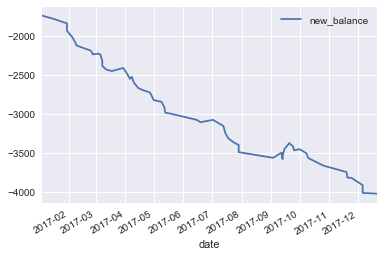

In [18]:
#test script: the balance of account 1 from 2017 to 2018
balance_time_series(return_account_trans(1,trans_df_temp,datetime(2017, 1, 1),datetime(2017, 12, 31)))

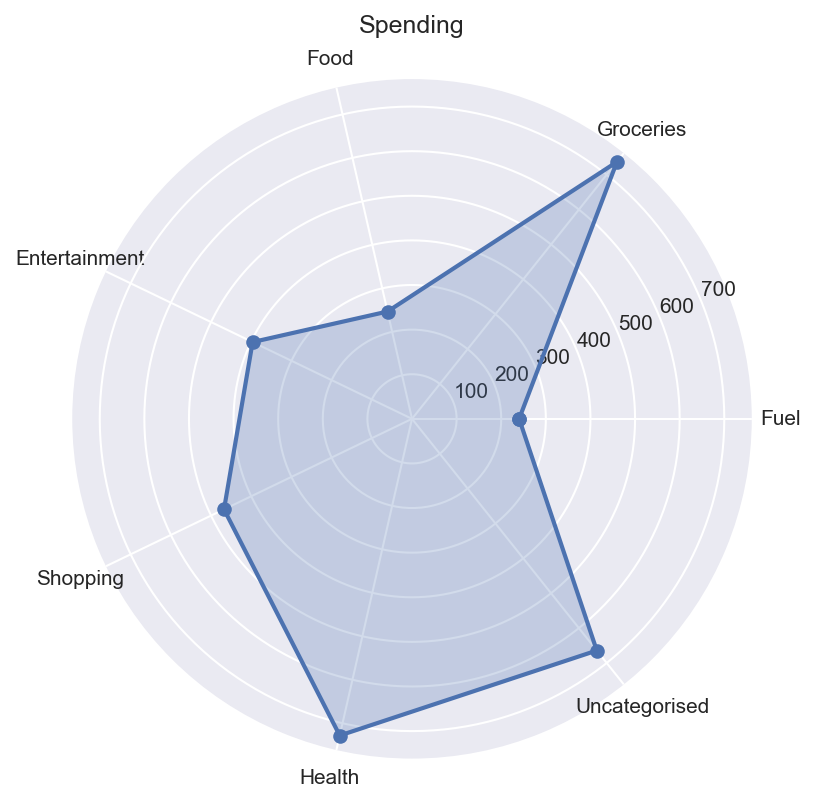

In [19]:
#test script: radar chart of account 20 spending in 2018
temp_df = return_account_trans(20,trans_df_temp,datetime(2018, 1, 1),datetime(2018, 12, 31))
radar_chart_categories(create_dataframe_spending(temp_df,0,0))

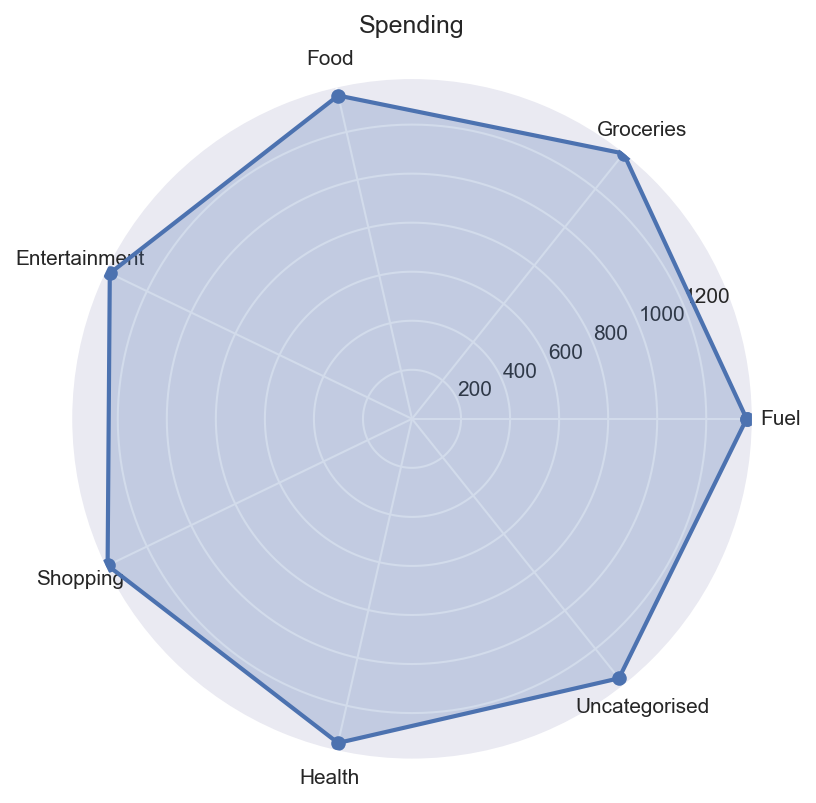

In [20]:
#test script: radar chart of average spending in all accounts
radar_chart_categories(calculate_average_spending(trans_df_temp,0,0))

### People Like You

A focus of our project is to personalise the banking app experience. Therefore, we want to give people information that may be more relevant to them. The phrase 'people like you' describes people of a similar age, who live in a similar location. Grouping people based on this, we can display them information that they may find interesting, and increase engagement.

In [21]:
def people_like_you_postcode(cus_df, cus_id):
    """
    returns a df of all customers with the same postcode 
    as the person whose ID is entered
    """
    i = 0
    pc = cus_df.at[cus_id,'postcode']
    cus_df = cus_df.loc[cus_df['postcode'] == pc]
    
    return cus_df

def people_like_you_birthrange(cus_df,cus_id):
    """
    returns a df of all customers within the same age group as cus_id
    """
    #TODO
    return cus_df

def account_id_from_cus_df(cus_df,acc_df):
    cus_id_list = cus_df.index.tolist()
    temp_df = acc_df[acc_df['client_id'].isin(cus_id_list)]
    
    return temp_df

def transactions_from_accounts(acc_df,trans_df,start_date,end_date):
    """
    This function returns all the transactions an account has made in a certain timeframe.
    Note: time range is optional. If not desired, call start_date as 0 and end_date as 0
    """
    templist = acc_df.index.tolist()
    df = trans_df[trans_df['account_id'].isin(templist)]
    if (start_date != 0) and (end_date != 0):
        df['date'] = pd.to_datetime(df['date'])
        mask = (df['date'] > start_date) & (df['date'] <= end_date)
        df = df.loc[mask]
        
    return df

def find_customer_accounts(cus_id,acc_df):
    df = acc_df.loc[acc_df['client_id'] == cus_id]
    return df

# People Like You 

In [22]:
def people_like_you(cus_id,cus_df,acc_df,trans_df,start_date,end_date):
    """
    Pre:   The ID of the customer, all customers, all accounts, all transactions and dates.
    Post:  A dataframe of the relevant spending categories containing the difference between average
           and 'your' spending. The higher the number, the more 'you' spent than the average.
           Uncategorised data is dropped from the dataframe, because this is automatically irrelevant.
           The returned dataframe can be empty if none of the differences are considered relevant by the
           PLU_Relevance helper function. There is no maximum number of relevant values to be returned.
           
    """
    #creating 'avg'
    
    #grouping people into postcodes
    df1 = people_like_you_postcode(cus_df,cus_id)
    
    #getting the accounts owned by all people like you
    df2 = account_id_from_cus_df(df1,acc_df)
    
    #getting the transactions of the accounts owned by PLU
    df3 = transactions_from_accounts(df2, trans_df,start_date,end_date)
    
    #creating spending dataframe of all PLU
    df4 = create_dataframe_spending(df3,start_date,end_date)
    
    #creating average spending table of all PLU
    avg_df = calculate_average_spending(df3,start_date,end_date)
    
    #creating 'you'
    
    #finding customer account of 'you'
    df6 = find_customer_accounts(cus_id,acc_df)
    
    #transactions by your accounts
    df7 = transactions_from_accounts(df6, trans_df,start_date,end_date)
    
    #creating a dataframe of your spending
    you_df = create_dataframe_spending(df7,start_date,end_date)
    
    #bar_cat_comparison(avg_df,you_df)
    
    df9 = avg_df.append(you_df)
    
    #return relevant categories
    return PLU_relevence(df9.drop(['Uncategorised'],axis=1))

def PLU_relevence(ret_df):
    """
    Pre:  A spending dataframe containing PLU 'avg' values, and PLU 'you' values.
    Post: The difference between 'avg' and 'you'. The higher the value, the higher the 'you' value.
          These differences are stored only in the relevant categories. Irrelevant categories are dropped.
          This relevance is determined as if the avg value + 10% is greater than the you value, it is not
          relevant
          
    Note: This is the function that determines PLU relevance, so the conditions can be changed here.
    """
    
    for i, values in ret_df.iteritems():
        
        avg = float(ret_df[i].iloc[0])
        you = float(ret_df[i].iloc[1])
        diff = you - avg
        
        ret_df[i].iloc[0] = diff
        
        if(avg*1.1>you):
            ret_df = ret_df.drop([i],axis=1)
            
    return ret_df.reset_index(drop=True).drop([1],axis=0)
    

def people_like_you_cat(cat,cus_id,cus_df,acc_df,trans_df,start_date,end_date):
    """
    Pre:  A desired category, the ID of the customer, all customers, all accounts, all transactions and dates.
    Post: Uses the people_like_you algorithm to create a relevence dataframe. Returns a dataframe which excludes
          all categories that are not the desired category. If the category isn't in the relevance dataframe,
          the program returns an empty frame.
    
    """
    
    #getting the results of the PLU algorithm
    cat_df = people_like_you(cus_id,cus_df,acc_df,trans_df,start_date,end_date)
    
    #dropping values that aren't category
    for i, values in cat_df.iteritems():
         if(i!=cat):
            cat_df = cat_df.drop([i],axis=1)
            
    return cat_df
    
    


# Recommend Voucher

In [23]:
def recommend_voucher(cus_id,cus_df,acc_df,trans_df,start_date,end_date):
    """
    Pre:  The output from a PLU function.
    Post: A recommendation towards the marketplace based on factors that determine relevance of recommendation (these 
          values may differ from what determines a relevant PLU value). Which item to recommend after relevance is
          determined is based on random chance.
    
    """
    
    #finding customer account of 'you'
    df6 = find_customer_accounts(cus_id,acc_df)
    
    #transactions by your accounts
    df7 = transactions_from_accounts(df6, trans_df,start_date,end_date)
    
    #creating a dataframe of your spending
    store_spending = create_dataframe_spending_store(df7,start_date,end_date)
    
    return recommend_voucher_cat(store_spending)
    

def recommend_voucher_cat(df):
    """
    Pre:  A dataframe containing a value of the difference between 'avg' and 'you' from a single category of PLU
    Post: A determination of whether or not this difference is reason enough to recommend the marketplace.
          In this instance, the function returns a yes or no value based on the value of diff.
    """
    
    for key, value in df.iterrows():
        if df.loc[key,'Spending'] < 50:
            df = df.drop(key,axis=0)
    
    return df.reset_index(drop=True)

In [24]:
people_like_you(50,cus_df_temp,acc_df_temp,trans_df_temp,datetime(2019, 1, 1),datetime(2019, 1, 31))

,Fuel,Shopping
0,18.53,53.93


In [25]:
people_like_you_cat('Shopping',39,cus_df_temp,acc_df_temp,trans_df_temp,0,0)

""
0


In [26]:
recommend_voucher(12,cus_df_temp,acc_df_temp,trans_df_temp,datetime(2019, 1, 1),datetime(2019, 1, 31))

,Store,Spending
0,Event Cinemas,93.40
1,Aldi,70.15
2,EB Games,75.20


In [27]:
people_like_you(39,cus_df_temp,acc_df_temp,trans_df_temp,0,0)

,Groceries
0,245.67


## Subscription Reminder

In [28]:
#---naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

#---KMeans Clustering 
from sklearn.cluster import KMeans

#---feature selection
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

#---data processing
from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

In [29]:
def data_analysis(seed, data, target):
    X_train= data.sample(frac = 0.5, replace = False, random_state=seed)
    X_test = data.drop(X_train.index)
    y_train = target.sample(frac = 0.5, replace = False, random_state=seed)
    y_test = target.drop(y_train.index)
       
    nb1 = []
    nb2 = []
    
    nb1 = nb(X_train,X_test,y_train,y_test)
    nb2 = nb(X_test,X_train,y_test,y_train)
    """
    enc = KBinsDiscretizer(n_bins=5, encode='ordinal')
    X_bin = enc.fit_transform(X_train)
    X_bin_test = enc.fit_transform(X_test)
    encmnb = MultinomialNB()
    encmnb.fit(X_bin, y_train)
    y_pred2 = encmnb.predict(X_bin_test)
      
    #---printing
    #print("Seed of:", seed, " |  Multinomial: ", np.mean(y_pred==y_test)," |  Discritized: ",np.mean(y_pred2==y_test), "\n")
    
    idx = []
    
    for key, val in y_test.iteritems():
        idx.append(key)
    
    df = pd.DataFrame(data=y_pred, index=idx)
    
    print(df)
    """
    
    arr = []
    arr.append(nb1[0].append(nb2[0]))
    arr.append((nb1[1]+nb2[1])/2)
    
    return arr

In [30]:
def nb(X_train,X_test,y_train,y_test):
  
    enc = KBinsDiscretizer(n_bins=5, encode='ordinal')
    X_bin = enc.fit_transform(X_train)
    X_bin_test = enc.fit_transform(X_test)
    encmnb = MultinomialNB()
    encmnb.fit(X_bin, y_train)
    y_pred2 = encmnb.predict(X_bin_test)
      
    #---printing
    #print("Seed of:", seed, " |  Multinomial: ", np.mean(y_pred==y_test)," |  Discritized: ",np.mean(y_pred2==y_test), "\n")
    
    idx = []
    
    for key, val in y_test.iteritems():
        idx.append(key)
    
    arr = []
    
    df = pd.DataFrame(data=y_pred2, index=idx)
    
    arr.append(df)
    arr.append(np.mean(y_pred2==y_test))
    
    return arr

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


def logreg(X_train,X_test,y_train,y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [32]:
def nb_data_prep(cus_id,trans_df,acc_df):
    df1 = find_customer_accounts(cus_id,acc_df)
    df2 = transactions_from_accounts(df1, trans_df,0,0)
    df2['account_to'] = df2['account_to'].astype('category')
    df2['account_to'] = df2['account_to'].cat.codes 
    
    df3 = df2.drop(['merchant_type','date','operation','account_from','new_balance','account_id'],axis=1)
    
    df4 = df2['date']
    day = []
    month = []
    year = []
    truesub = []
    
    for key, value in df2['merchant_type'].iteritems():
        if value is 'Subscription':
            truesub.append(1)
        else:
            truesub.append(0)
            
    df2['truesub'] = truesub
    
    for key, value in df4.iteritems():
        #if isinstance(value, datetime.datetime):
        day.append(value.strftime('%d'))
        month.append(value.strftime('%m'))
        year.append(value.strftime('%Y'))
        """else: 
            d = value.split('/')
            day.append(d[0])
            month.append(d[1])
            year.append(d[2])
        """
        
    df3['Day'] = day
    df3['Month'] = month
    df3['Year'] = year
    
    return [df3,df2['truesub']]


In [33]:
def get_subscriptions(index_df,cus_id,trans_df,acc_df):
    df1 = find_customer_accounts(cus_id,acc_df)
    df2 = transactions_from_accounts(df1, trans_df,0,0)
    
    droplist = []
    
    
    for key, value in index_df.iterrows():
        if value.item() is 0:
            df2 = df2.drop([key])
            
    return df2.drop(droplist)
    

In [34]:
def predict_next_subscription(df):
    df = df.sort_values(by=['date','account_to','amount'],ascending=False)
    sub_df = df[df.duplicated(subset=['account_to','amount'], keep=False)].reset_index(drop=True)
    df = sub_df.drop_duplicates(subset=['account_to','amount'])
    
    columns = ['Last Payment','Next Payment', 'Name of Vendor','Amount']
    
    ret_df = pd.DataFrame(columns=columns)
      
    ret_df['Last Payment'] = df['date']
    ret_df['Next Payment'] = determine_date_difference(sub_df)
    ret_df['Name of Vendor'] = df['account_to']
    ret_df['Amount'] = df['amount']
    
    ret_df = ret_df.reset_index(drop=True)
    
    return ret_df
    
    

In [35]:
def determine_date_difference(df):
    """
    Pre:  dataframe of subscriptions
    Post: array of next payment dates for subscriptions
    
    """
    #print(df, '\n')
    
    df1 = df.drop_duplicates(subset=['account_to','amount'])
    df2 = df.drop(df1.index.values).drop_duplicates(subset=['account_to','amount'])
    
    df1 = df1.sort_values(by=['account_to','amount'],ascending=False).reset_index(drop=True)
    df2 = df2.sort_values(by=['account_to','amount'],ascending=False).reset_index(drop=True)
    
    #print(df1, '\n')
    #print(df2)
    
    arr = []
    idx = []
    
    temp = []
    i = 0
    
    for key, value in df1.iterrows():
        date = df1.at[key,'date']
        date = date - df2.at[key,'date']
        arr.append(date)
        idx.append(key)
              
        
    for i in range(len(arr)):
        if arr[i].days > 30:
            arr[i] = add_dates(df1.at[idx[i],'date'],'month')
        
        elif 7 < arr[i].days <= 14:
            arr[i] = add_dates(df1.at[idx[i],'date'],'biweekly')
            
        elif arr[i].days >= 7:
            arr[i] = add_dates(df1.at[idx[i],'date'],'week')
    
    return arr
    

In [42]:
def subscription_reminder(cus_id,trans_df,acc_df):
    data = nb_data_prep(cus_id,trans_df,acc_df)

    arr = [0,0]
    temp = []

    #this loop runs the analysis several times and chooses the most accurate result
    for i in range (10, 110, 10):
        temp = data_analysis(i,data[0],data[1])
        if arr[1] < temp[1]:
            arr = temp
            arr[0] = get_subscriptions(arr[0],cus_id,trans_df,acc_df)
        
    #if there is a dataframe to show, proceed 
    if not arr[0].empty:
        df = predict_next_subscription(arr[0])
        for key, value in df['Next Payment'].iteritems():
            if type(value) is timedelta or type(value) is pd._libs.tslibs.timedeltas.Timedelta:
                df = df.drop(key,axis=0)
                continue
            if value < date(2019, 6, 2):
                df = df.drop(key,axis=0)
        
        return df.reset_index(drop=True)
    else:
        return pd.DataFrame(columns = ['Last Payment','Next Payment', 'Name of Vendor','Amount'])

In [43]:
print(subscription_reminder(56,trans_df_temp,acc_df_temp))

Empty DataFrame
Columns: [Last Payment, Next Payment, Name of Vendor, Amount]
Index: []


In [44]:
i = 1
j = 130
while i <= j:

    tdf = subscription_reminder(i,trans_df_temp,acc_df_temp)
    print(tdf, '\n')
    i+=1

  Last Payment Next Payment Name of Vendor Amount
0   2019-05-15   2019-06-29         HBO Go  14.99 

  Last Payment Next Payment Name of Vendor Amount
0   2019-04-29   2019-06-03       Dashlane   9.99
1   2019-04-13   2019-06-13        Netflix     20 

Empty DataFrame
Columns: [Last Payment, Next Payment, Name of Vendor, Amount]
Index: [] 

Empty DataFrame
Columns: [Last Payment, Next Payment, Name of Vendor, Amount]
Index: [] 

Empty DataFrame
Columns: [Last Payment, Next Payment, Name of Vendor, Amount]
Index: [] 

  Last Payment Next Payment Name of Vendor Amount
0   2019-05-30   2019-06-13        Spotify  14.99
1   2019-05-25   2019-06-03       Dashlane     10
2   2019-05-02   2019-06-06         HBO Go  14.99
3   2019-03-21   2019-06-08        Netflix  14.99 

Empty DataFrame
Columns: [Last Payment, Next Payment, Name of Vendor, Amount]
Index: [] 



KeyboardInterrupt: 

In [ ]:
trans_df_temp